In [243]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /private/var/folders/wx/fzmjh7k14k500bnyqlpwchtc0000gp/T/pip-install-3jrp73b8/polara_b3b6051112c9426ba52377a62247cb38
  Running command git clone -q https://github.com/evfro/polara.git /private/var/folders/wx/fzmjh7k14k500bnyqlpwchtc0000gp/T/pip-install-3jrp73b8/polara_b3b6051112c9426ba52377a62247cb38
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  branch 'develop' set up to track 'origin/develop'.


# Imports

In [345]:
import seaborn as sns
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import statistics as stat
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder

import polara
from polara import get_movielens_data
from polara.tools.display import print_frames

# Data preparation

## Download

The data about users' ratings and movies will be downloaded using polara.

In [245]:
# ?get_movielens_data

In [273]:
ratings, genres = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

ratings.shape

(1000209, 4)

In [274]:
movies = genres
movies.shape

(3883, 3)

In [275]:
users = pd.read_csv("users.csv")
users.shape

(6040, 5)

## Description

In [276]:
ratings.nunique()

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

In [277]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [278]:
movies.head()

,movieid,movienm,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [279]:
users.head()

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Text(0.5, 1.0, 'Ratings Distribution')

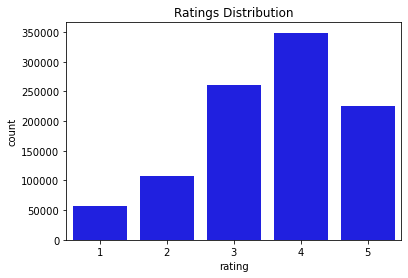

In [280]:
sns.countplot(x = "rating", data = ratings, color = "blue").set_title("Ratings Distribution")

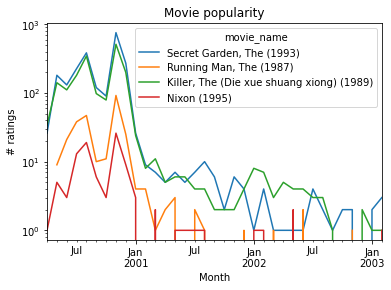

In [281]:
select_movies = [13, 527, 1200, 3629]
(
    ratings
    .set_index(pd.to_datetime(ratings['timestamp'], unit='s'))
    .query('movieid in @select_movies')
    .assign(movie_name=lambda x: x['movieid'].map(movies['movienm']))
    .groupby('movie_name', sort=False)
    .resample('M') # monthly
    .size() # total count
    .unstack(level='movie_name')
    .plot(logy=True, title='Movie popularity', xlabel='Month', ylabel='# ratings')
);

## Preprocessing

### Movie data

Genre splitting

In [282]:
genres = set()

for movie_genres in movies["genres"]:
  for genre in movie_genres.split("|"):
    genres.add(genre)

In [283]:
col = 2
for genre in genres:
  movies.insert(col, genre, np.zeros(len(movies["genres"]), int))
  col += 1

In [284]:
for index, row in movies.iterrows():
  for genre in row["genres"].split("|"):
    movies.loc[index, genre] = 1

movies = movies.drop(["movienm", "genres"], axis = 1)
movies.head()

,movieid,Adventure,Documentary,Romance,Musical,Fantasy,Children's,Horror,War,Comedy,Crime,Mystery,Film-Noir,Sci-Fi,Action,Drama,Western,Animation,Thriller
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,2,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Ratings data

#### Top-n movies collection

In [285]:
n = 30

top_movies_index = ratings.groupby("movieid").count().sort_values("userid", ascending = False).head(n).reset_index()["movieid"]
top_movies_index.head()

0    2858
1     260
2    1196
3    1210
4     480
Name: movieid, dtype: int64

In [286]:
top_movies = movies[movies.movieid.isin(top_movies_index)]
top_movies.shape

(30, 19)

In [287]:
filtered_ratings_original = ratings[ratings["movieid"].isin(top_movies_index)]
filtered_ratings_original.shape

(73972, 4)

In [288]:
filtered_ratings_original.loc[:, "reward"] = np.where(filtered_ratings_original["rating"] < 5, 0, 1)
filtered_ratings_original.head()

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,userid,movieid,rating,timestamp,reward
5,1,1197,3,978302268,0
22,1,1270,5,978300055,1
23,1,527,5,978824195,1
26,1,1097,4,978301953,0
38,1,2762,4,978302091,0


In [289]:
filtered_ratings_original = filtered_ratings_original.reset_index(drop = True)

<AxesSubplot:>

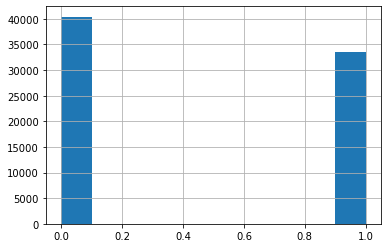

In [290]:
filtered_ratings_original.reward.hist()

In [291]:
reward_mean = filtered_ratings_original.reward.mean()
reward_mean

0.45364462228951496

In [292]:
# Reshuffling rows to randomise it
np.random.seed(42)
filtered_ratings = filtered_ratings_original.reindex(np.random.permutation(filtered_ratings_original.index)).reset_index(drop = True)
filtered_ratings = filtered_ratings_original.reset_index(drop = True)

#### Splitting

In [293]:
#def leave_last_out(data, userid='userid', timeid='timestamp'):
    #sorted = data.sort_values(timeid)
    #holdout = sorted.drop_duplicates(subset=[userid], keep='last')
    #remaining = data.drop(holdout.index)
    #return remaining, holdout

In [294]:
#training_, holdout_ = leave_last_out(filtered_ratings)

In [295]:
#training_.head()

In [296]:
#holdout_.head()

The below code block performs the checking that the split into training and holdout set was done correctly. It is done by comparing that all "userid" value in the holdout set are greater than or equal than the maximum value contained in "userid" in the training.

In [297]:
#assert holdout_.set_index('userid')['timestamp'].ge(
 #   training_
  #  .groupby('userid')
   # ['timestamp'].max()
#).all()

#### Index transformation

In [298]:
#def transform_indices(data, users, items):
   # data_index = {}
   # for entity, field in zip(['users', 'items'], [users, items]):
   #     idx, idx_map = to_numeric_id(data, field)
   #     data_index[entity] = idx_map
   #     data.loc[:, field] = idx # inplace operation!
   # return data, data_index

#def to_numeric_id(data, field):
   # idx_data = data[field].astype("category")
   # idx = idx_data.cat.codes
   # idx_map = idx_data.cat.categories.rename(field)
   # return idx, idx_map

#def reindex_data(data, entity, data_index):
   # field = data_index[entity].name
   # new_index = data_index[entity].get_indexer(data[field])
   # return data.assign(**{f'{field}': new_index})

In [299]:
# build new index and
#training, data_index = transform_indices(training_, 'userid', 'movieid')

In [300]:
#print_frames([training.head(), ratings.head()])

In [301]:
# apply new index to holdout
#holdout = reindex_data(holdout_, 'items', data_index)

#### Data consistency check

In [302]:
#holdout.query('movieid<0')

In [303]:
#holdout = holdout.query('movieid >= 0')

### User data

In [304]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

users['agegroup'] = pd.cut(users['age'], bins, labels=names)
users = users.drop(["age"], axis = 1)
users.head()

,userid,gender,occupation,zipcode,agegroup
0,1,F,10,48067,<20
1,2,M,16,70072,51-60
2,3,M,15,55117,20-29
3,4,M,7,02460,40-49
4,5,M,20,55455,20-29


In [305]:
users["occupation"] = users["occupation"].map({
	  0:  "other or not specified",
	  1:  "academic/educator",
	  2:  "artist",
	  3:  "clerical/admin",
	  4:  "college/grad student",
	  5:  "customer service",
	  6:  "doctor/health care",
	  7:  "executive/managerial",
	  8:  "farmer",
	  9:  "homemaker",
	 10:  "K-12 student",
	 11:  "lawyer",
	 12:  "programmer",
	 13:  "retired",
	 14:  "sales/marketing",
	 15:  "scientist",
	 16:  "self-employed",
	 17:  "technician/engineer",
	 18:  "tradesman/craftsman",
	 19:  "unemployed",
	 20:  "writer"})

In [306]:
columnsToEncode = ["agegroup", "gender", "occupation"]
myEncoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
myEncoder.fit(users[columnsToEncode])

users_d = users.drop(columnsToEncode, axis = 1)

users = pd.concat([users_d,
                   pd.DataFrame(myEncoder.transform(users[columnsToEncode]).astype(int),
                   columns = myEncoder.get_feature_names(columnsToEncode))],
                                                         axis=1).reindex()
users = users.drop(["zipcode"], axis = 1)
print(users.shape)
users.head()

(6040, 29)


,userid,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_<20,gender_F,gender_M,occupation_K-12 student,occupation_academic/educator,...,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer
0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# ε-greedy approach (uncompleted) reaslisation

In [333]:
'''
class BernoulliArm():
    
    def __init__(self, p):
        
        # p: probability of success
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        
        if np.random.rand() > self.p:
            return 0.0
        
        else:
            return 1.0
'''

In [334]:
'''
class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values):
        
        self.epsilon = epsilon
        
        # counts: counts of pulls for each arm
        self.counts = counts
        
        #values: average reward for specific arm
        self.values = values
    
    # Initialise k number of arms
    def initialize(self, n_arms):
        
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    # Epsilon greedy arm selection
    def select_arm(self):
        
        # If prob is not in epsilon, do exploitation of best arm so far
        if np.random.rand() > self.epsilon:
            return np.argmax(self.values)
        
        # If prob falls in epsilon range, do exploration
        else:
            return random.randrange(len(self.values))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return
'''

In [335]:
'''
def test_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]
'''

# LinUCB Disjoint approach realisation

In [307]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():

    def __init__(self, arm_index, d, alpha):

        self.arm_index = arm_index
        self.alpha = alpha

        # A: (d x d) matrix = D.T * D + I
        self.A = np.identity(d)

        # b: (d x 1) response vector = D.T * c (in ridge regression formulation)
        self.b = np.zeros([d,1])

    def calc_UCB(self, x_array):
        
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta: (d x 1) dimension vector = A_inv * b
        self.theta = np.dot(A_inv, self.b)

        # UCB: (1 x 1) dimension vector = expected_reward + alpha * std_dev
        expected_reward = np.dot(self.theta.T, x_array)
        std_dev = np.sqrt(np.dot(x_array.T, np.dot(A_inv, x_array)))
        UCB = expected_reward +  self.alpha * std_dev

        return UCB

    def reward_update(self, reward, x_array):
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)

        # Update b which is (d x 1) vector
        self.b += reward * x_array

In [308]:
class linucb_disjoint_policy():

    def __init__(self, K_arms, d, alpha):
        
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]

    def select_arm(self, x_array):
        
        highest_UCB = -1

        # Track index of arms to be selected on if they have the max UCB
        candidate_arms = []

        for arm_index in range(self.K_arms):
            
            # Calculate UCB based on each arm using current covariates at time t
            arm_UCB = self.linucb_arms[arm_index].calc_UCB(x_array)

            # If current arm's UCB is higher than current highest_UCB
            if arm_UCB > highest_UCB:

                # Set new highest_ucb
                highest_UCB = arm_UCB

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_UCB == highest_UCB:

                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly
        chosen_arm = np.random.choice(candidate_arms)

        return chosen_arm

    def store_arm_index(self, arms_index_array):

        # Loop through all arms to store their indices
        for i in range(self.K_arms):

            self.linucb_arms[i].arm_index = arms_index_array[i]

In [309]:
def ctr_disjoint_simulator(K_arms, d, alpha, epochs, top_movies_index, steps_printout):
    
    # Initiate policy
    linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)

    # Store specific arm_index
    linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):

            user_id = ratings.loc[i,"userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x: User features
            ratings_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            ratings_x_array = ratings_x_array.reshape(28, 1)

            ratings_reward = ratings.loc[i, "reward"]

            if i % steps_printout == 0:
                print("Step " + str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(ratings_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(ratings_reward, 
                                                                                          ratings_x_array)
                
                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy": linucb_disjoint_policy_object}

In [310]:
alpha_value = 0.5
simulation_disjoint_alpha_05 = ctr_disjoint_simulator(K_arms = n,
                                                       d = 28,
                                                       alpha = alpha_value,
                                                       epochs = 2,
                                                       top_movies_index = top_movies_index,
                                                       steps_printout=5000)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


Text(0.5, 1.0, 'alpha = 0.5')

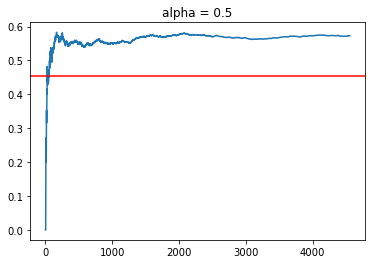

In [321]:
plt.plot(simulation_disjoint_alpha_05["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = " + str(alpha_value))

# LinUCB Hybrid approach realisation

In [322]:
class linucb_hybrid_arm():
    
    # Shared features coefficients beta_hat are calculated
    # outside of each arm (since they are shared features)

    def __init__(self, d, k, alpha):

        # A: (d * d) matrix = D.T * D + I
        self.A = np.identity(d)

        # B: (d * k) matrix = D.T * c
        self.B = np.zeros([d, k])

        # b: (d * 1) response vector = D.T * c
        self.b = np.zeros([d, 1])

        self.alpha = alpha

    def init_arm_features(self, arm_index, arm_features_array):
        # Track arm_index
        self.index = arm_index

        # arm_features to be used with x_array using outer product
        # to find individual arm z_features
        self.arm_features = arm_features_array


    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        
        # beta_hat is the coefficients for shared features: (k * 1) vector
        # A_node_inv: (k * k) inverse matrix of A_node (shared features)

        # z_array: (k by d) matrix = arm_features * x_array
        z_array = np.outer(self.arm_features, x_array).reshape(-1, 1)

        # Find A inverse for ridge regression (arm-specific)
        A_inv = np.linalg.inv(self.A)

        # theta_arm = A_inv * (b - B * beta_hat)
        self.theta = np.dot(A_inv, (self.b - np.dot(self.B, beta_hat)))

        # std deviation
        pr1 = np.dot(z_array.T, np.dot(A_node_inv, z_array))
        pr2 = np.dot(z_array.T,
                     np.dot(A_node_inv, np.dot(self.B.T,
                                               np.dot(A_inv, x_array))))
        pr3 = np.dot(x_array.T, np.dot(A_inv, x_array))
        pr4 = np.dot(x_array.T,
                     np.dot(A_inv,
                            np.dot(self.B,
                                   np.dot(A_node_inv,
                                          np.dot(self.B.T,
                                                 np.dot(A_inv, x_array))))))

        s = pr1 - 2 * pr2 + pr3 + pr4


        # UCB = z_array.T * beta_hat + x_array.T * theta + alpha * sqrt(std_dev)
        UCB = np.dot(z_array.T, beta_hat) + np.dot(x_array.T, self.theta) \
              + self.alpha * np.sqrt(s)

        return UCB

    def reward_update(self, reward, x_array, z_array):

        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)

        # Update B which is (d * k) matrix.
        self.B += np.dot(x_array, z_array.T)

        # Update b which is (d * 1) vector
        # reward is scalar
        self.b += reward * x_array

In [323]:
class linucb_hybrid_policy():

    def __init__(self, K_arms, d, k, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d = d, k = k, alpha = alpha) for i in range(K_arms)]

        # shared A_node: (k * k) matrix
        self.A_node = np.identity(k)

        # shared b_node: (k * 1) corresponding response vector.
        self.b_node = np.zeros([k, 1])

    def store_arm_features(self, arms_features_array):

        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):

            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i, 0],
                                                  arm_features_array = arms_features_array[i, 1:])

    def select_arm(self, x_array):
        
        highest_UCB = -1

        # Create inverse of A_node
        A_node_inv = np.linalg.inv(self.A_node)


        # beta_hat: (k * 1) vector = A_node_inv * b_node
        beta_hat = np.dot(A_node_inv, self.b_node)

        # Track index of arms to be selected on if they have the max UCB
        candidate_arms = []

        for arm_index in range(self.K_arms):
            
            # Calculate UCB based on each arm using current covariates at time t
            arm_UCB = self.linucb_arms[arm_index].calc_UCB(x_array, A_node_inv, beta_hat)

            if arm_UCB > highest_UCB:

                # Set new highest_UCB
                highest_UCB = arm_UCB

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_UCB == highest_UCB:

                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly
        chosen_arm_index = np.random.choice(candidate_arms)

        return chosen_arm_index

    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        
        # Use chosen arm's B: (d*k), A: (d*d), b: (k*1) for update of shared feature matrices
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        # A_node = A_node + B.T * A_node_inv * B
        self.A_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        
        # b_node = b_node + B.T * A_node_inv * b
        self.b_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):

        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        # A_node = A_node + z * z.T - B.T * A_node_inv * B
        self.A_node += np.dot(z_array, z_array.T) - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        
        # b_node = b_node + reward * z - B.t * A_node_inv * b
        self.b_node += reward * z_array - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

In [326]:
def ctr_hybrid_simulator(K_arms, d, k, alpha, epochs, top_movies_index, top_movies_features, steps_printout):
    
    # Initiate policy
    linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms = K_arms, d = d,
                                                       k = k, alpha = alpha)

    # Store arm specific features
    linucb_hybrid_policy_object.store_arm_features(top_movies_features.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings dataframe
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        else:
            
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):
            
            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x_array: User features
            ratings_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            ratings_x_array = ratings_x_array.reshape(28, 1)

            ratings_reward = ratings.loc[i, "reward"]

            if i % steps_printout == 0:
                print("step " + str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(ratings_x_array)


            # Check if arm_index is the same as ratings_arm (ie same actions were chosen)
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index  == movie_id:


                # Phase 1: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # Extract chosen_arm arm_features to create z_array
                ratings_z_array = np.outer(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, 
                                        ratings_x_array).reshape(-1,1)

                # Use reward information for the chosen arm to update
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(ratings_reward, 
                                                                                        ratings_x_array, 
                                                                                        ratings_z_array)

                # Phase 2: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(ratings_z_array, ratings_reward,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy":linucb_hybrid_policy_object}

In [327]:
alpha_value = 0.5
simulation_hybrid_alpha_05 = ctr_hybrid_simulator(K_arms = n,
                                                  d = 28,
                                                  k = 28 * 18,
                                                  alpha = alpha_value,
                                                  epochs = 2,
                                                  top_movies_index = top_movies_index,
                                                  top_movies_features = top_movies,
                                                  steps_printout = 5000)

Epoch: 0
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000
Epoch: 1
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000


Text(0.5, 1.0, 'alpha = 0.5')

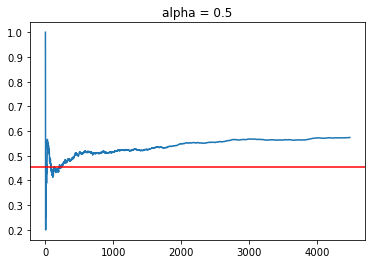

In [328]:
plt.plot(simulation_hybrid_alpha_05["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = " + str(alpha_value))

# Results Comparison

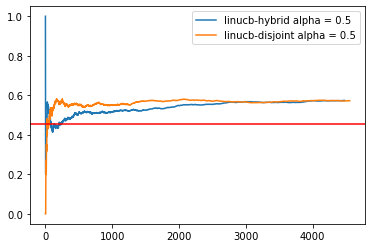

In [329]:
plt.plot(simulation_hybrid_alpha_05["ctr"], label = "linucb-hybrid alpha = 0.5")
plt.plot(simulation_disjoint_alpha_05["ctr"], label = "linucb-disjoint alpha = 0.5")
plt.axhline(y=reward_mean, color = "red")
plt.legend()